This notebook is for questions 4: Forecast of monthly sales volumes by product category


In [1]:
%pip install pymysql

import matplotlib.pyplot as plt
import os
import pymysql
import pandas as pd
import numpy as np

succeess = False

while not succeess:
  try:
    conn = pymysql.connect(
        host='db-aff.cpapv35x7rsh.us-east-2.rds.amazonaws.com',
        port=int(3306),
        user="admin",
        passwd="olist2021",
        db='olist',
        charset='utf8mb4')
    db = conn.cursor()
    succeess = True
  except:
    print("Wrong Password")

print("Connection Made")


def add_quotes(s):
  return '"'+str(s)+'",'

def add_quotes_nocomma(s):
  return '"'+str(s)+'"'

     |████████████████████████████████| 43 kB 855 kB/s 
Connection Made


In [2]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar

In [ ]:
pip install -U seaborn

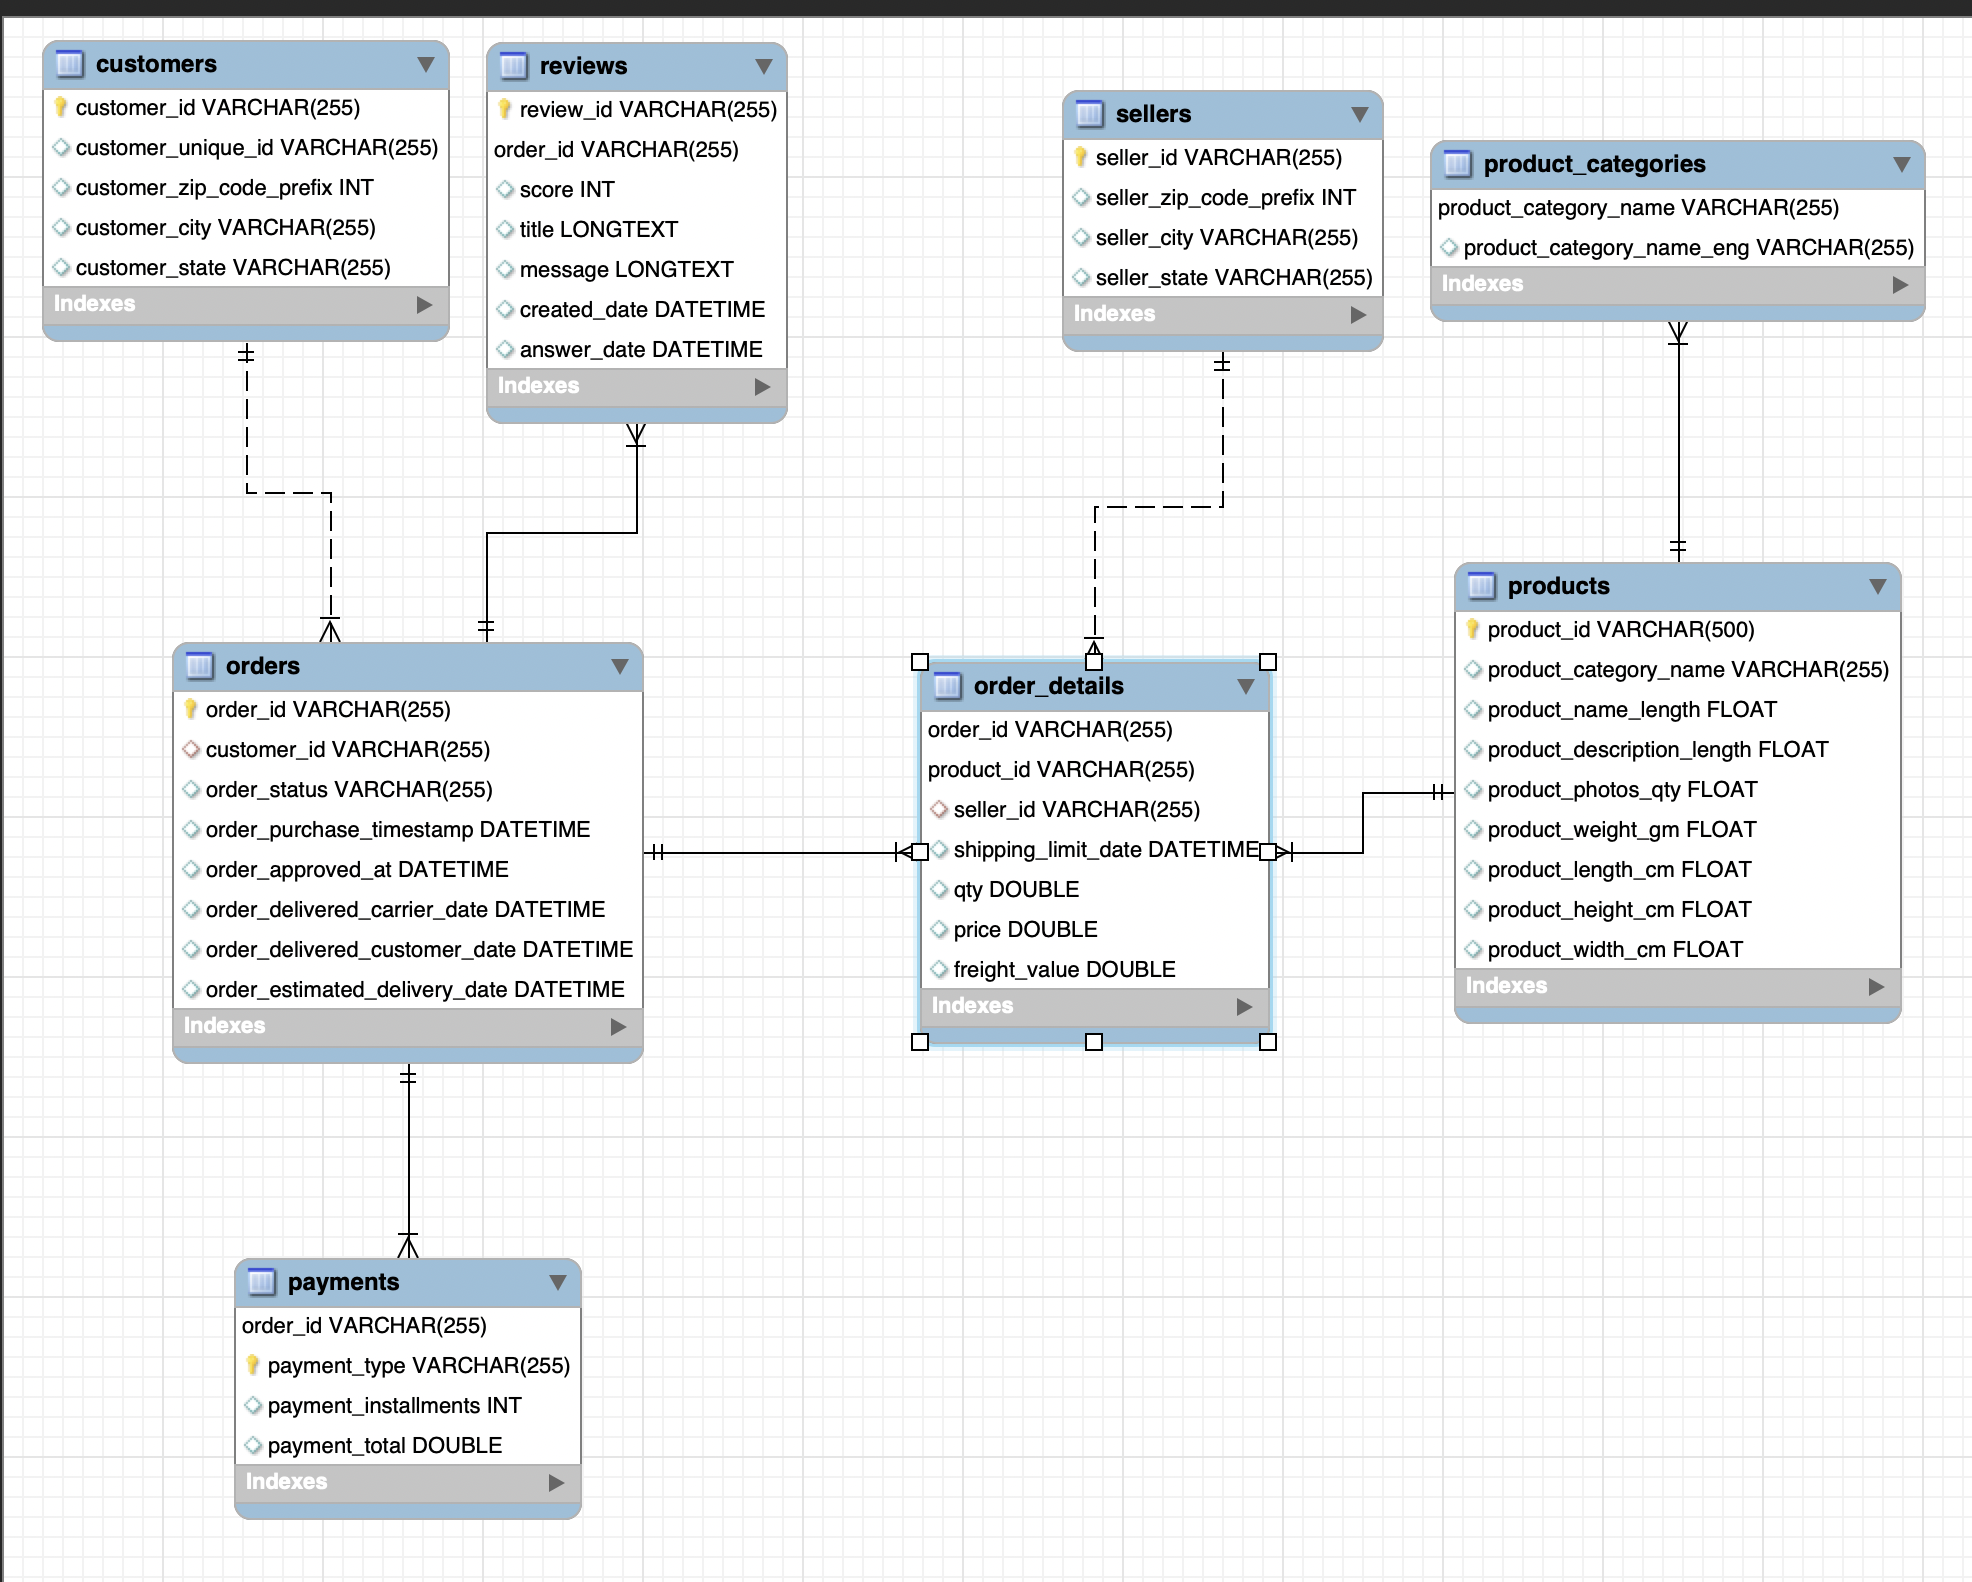

In [3]:
#(string query, connection from the first code block above)
products = pd.read_sql_query("SELECT * from olist.products", conn)
payments = pd.read_sql_query("SELECT * from olist.payments", conn)
orders = pd.read_sql_query("SELECT * from olist.orders", conn)
order_details = pd.read_sql_query("SELECT * from olist.order_details", conn)
customers = pd.read_sql_query("SELECT * from olist.customers", conn)
reviews = pd.read_sql_query("SELECT * from olist.reviews", conn)
sellers = pd.read_sql_query("SELECT * from olist.sellers", conn)
product_categories = pd.read_sql_query("SELECT * from olist.product_categories", conn)

In [4]:
products.info()
orders.info()
order_details.info()
product_categories.info()
payments.info()
reviews.info()
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_length         32951 non-null  float64
 3   product_description_length  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_gm           32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --

In [5]:
order_details.order_id.nunique()

98666

There are orders in 'orders' table that are not in 'order details' table. Hence left join by 'order details' table so that we have info on price, freight, etc. on each order.

In [6]:
#left join orders and order_details, there is no NA
all_orders = pd.merge(order_details, orders, on='order_id',how='left')
len(all_orders)
#all[all.isnull().any(axis=1)]
#same order_id can have multiple different product_ids

102425

In [7]:
#From the payments table, calculate total payments per order id. However, for sales prediction we will not use this but use total price+freight to calculate sales values
payment_group = payments.groupby(['order_id'])['payment_total'].sum().reset_index()
payment_group.head(5)

,order_id,payment_total
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [8]:
#Join the product table with the category translation table so we have English names of the order categories
product_complete = pd.merge(products, product_categories, on='product_category_name', how = 'left')
#product_complete.product_category_name_eng.unique()

In [9]:
#Some product categories are available in portuguese but not english. We translate those manually here. There are NULL values for categories still.
product_complete.loc[product_complete['product_category_name']=='pc_gamer', 'product_category_name_eng'] = 'pc_gamer'
product_complete.loc[product_complete['product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_eng'] = 'kitchen_dining_laundry_garden_furniture'
product_complete[product_complete.isnull().any(axis=1)].product_category_name.unique()

array(['nan'], dtype=object)

In [10]:
#Join the order details table with product category table
sales = pd.merge(all_orders, product_complete[['product_id', 'product_category_name_eng', 'product_photos_qty', 'product_description_length', 'product_name_length']], on='product_id',how='left')
#there is one order with order details but no payment info.
#check for null values in the dataset. null values are all in the product category column 
#sales[sales.isnull().any(axis=1)]

In [11]:
#Calulate and insert a total_price columns:
sales['total_price'] = sales.apply(lambda row: row.qty*(row.price + row.freight_value), axis=1)
#check orders that have >1 products to make sure total price was calculated correctly
#sales[sales['qty']>1]

In [ ]:
#Check total payments and total prices, there are 255 rows where payment is different from total price. The amount is insignificant so we will leave them there (do not remove them)
#sales[['order_id', 'total_price','payment_total']]
#sales = sales.groupby(['order_id','payment_total'])['total_price'].sum().reset_index()
#sales['diff_pay'] = sales.apply(lambda row: round((row.payment_total-row.total_price),0), axis=1)
#diff=sales[sales['diff_pay']!=0]
#diff.sort_values(by='diff_pay', ascending=False)

In [12]:
sales.product_category_name_eng.unique()

array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto', nan,
       'home_appliances', 'kitchen_dining_laundry_garden_furniture',
       'air_conditioning', 'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tools_safety', 'c

In [13]:
sales2 = sales.copy()

In [14]:
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['agro_industry_and_commerce','industry_commerce_and_business'],'Agro Industry')

In [15]:
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['art','arts_and_craftmanship','party_supplies', 'stationery','flowers', 'christmas_supplies'],'Arts')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['books_general_interest','books_imported','books_technical','cine_photo'],'Books')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['construction_tools_construction','construction_tools_lights', 'construction_tools_safety', 'construction_tools_garden','costruction_tools_tools','costruction_tools_garden'],'Construction')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['air_conditioning', 'computers','computers_accessories', 'consoles_games', 'dvds_blu_ray', 'electronics', 'fixed_telephony', 'small_appliances' , 'auto','small_appliances_home_oven_and_coffee', 'tablets_printing_image','telephony','pc_gamer'],'Electronics')

sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['toys','baby','fashion_childrens_clothes','fashion_bags_accessories','cool_stuff', 'fashion_female_clothing', 'fashion_bag_accessories', 'fashion_children_clothing','fashio_female_clothing','diapers_and_hygiene', 'fashion_male_clothing', 'fashion_shoes', 'fashion_underwear_beach', 'fashion_sport', 'health_beauty' , 'perfumery' , 'sports_leisure','watches_gifts'],'Fashion and Beauty')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['bed_bath_table', 'furniture_bedroom', 'furniture_decor', 'furniture_living_room', 'furniture_mattress_and_upholstery', 'garden_tools', 'kitchen_dining_laundary_garden_furniture', 'kitchen_dining_laundry_garden_furniture','luggage_accessories','office_furniture'],'Furniture')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['home_appliances', 'home_comfort', 'home_confort', 'home_construction', 'housewares','home_comfort_2', 'home_appliances_2'],'Home Appliances')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['audio','music','musical_instruments', 'cds_dvds_musicals'],'Musical Instrument')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['security_and_services','signaling_and_security'],'Security Services')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['food','drinks','la_cuisine','food_drink'],'Food and Drink')
sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['pet_shop'],'Pet')

sales2['product_category_name_eng'] = sales2['product_category_name_eng'].replace(['market_place'],'Market Place')


In [16]:
sales2.product_category_name_eng.unique()

array(['Fashion and Beauty', 'Pet', 'Furniture', 'Home Appliances',
       'Electronics', 'Books', 'Food and Drink', 'Agro Industry',
       'Construction', 'Musical Instrument', 'Arts', nan,
       'Security Services', 'Market Place'], dtype=object)

I want to calculate sale volumes per category per month. Will be using orders, order_items, and products dataset. 


In [17]:
#total sale values (sum total_price) by category
sales_val = sales.groupby(['product_category_name_eng'])['total_price'].sum().reset_index()
sales_val.sort_values('total_price', ascending=False)

sales_val15 = sales_val.sort_values('total_price', ascending=False).head(15)

#.iloc[::-1]
sales_val15['total_price'].sum()/sales_val['total_price'].sum()
#top 20 categories make up for 85% of sales revenues

0.7742777004392948

In [18]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fK' % (x*1000*1e-6)

formatter = FuncFormatter(millions)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


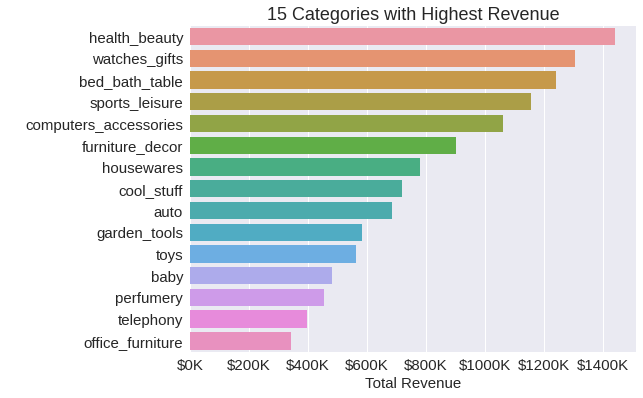

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(sales_val15.total_price,sales_val15.product_category_name_eng, orient='h')
ax.set_title('15 Categories with Highest Revenue', fontsize=18)
ax.set_xlabel('Total Revenue', fontsize=15)
ax.set_ylabel(' ', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [20]:
#total sales volumes (count of products) by categories, 
sales_vol= sales.groupby(['product_category_name_eng'])['qty'].sum().reset_index()
sales_vol.sort_values(by='qty',ascending=False)
sales_vol15 = sales_vol.sort_values('qty', ascending=False).head(15)
sales_vol15['qty'].sum()/sales_vol['qty'].sum()
#top 20 categories make up for 88% of sales volumes

0.7999585760984088

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


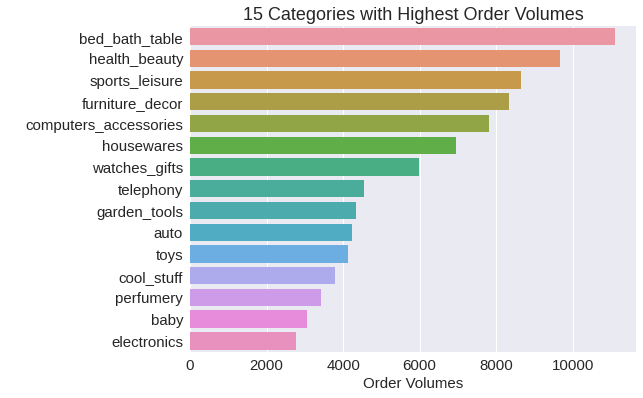

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(sales_vol15.qty,sales_vol15.product_category_name_eng, orient='h')
ax.set_title('15 Categories with Highest Order Volumes', fontsize=18)
ax.set_xlabel('Order Volumes', fontsize=15)
ax.set_ylabel(' ', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


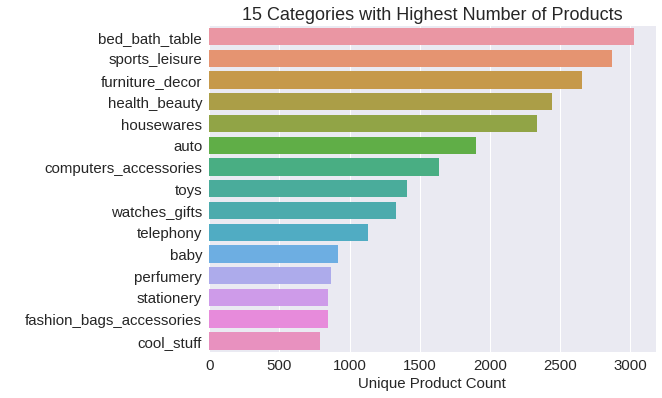

In [22]:

fig, ax = plt.subplots(figsize=(8, 6))

sales_product = sales.groupby(by=['product_category_name_eng'], as_index=False).agg({"product_id": pd.Series.nunique})
sales_product15 = sales_product.sort_values('product_id', ascending=False).head(15)


#top 20 categories make up for 88% of sales volumes
sns.barplot(sales_product15.product_id,sales_product15.product_category_name_eng, orient='h')
ax.set_title('15 Categories with Highest Number of Products', fontsize=18)
ax.set_xlabel('Unique Product Count', fontsize=15)
ax.set_ylabel(' ', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [23]:
sales_product15['product_id'].sum()/sales_product['product_id'].sum()

0.7736000742092082

In [24]:
navalue = '0000-00-00 00:00:00' #reviews_orders_df.iloc[89, :]['order_delivered_customer_date']
cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
indices = np.array([True] * sales.shape[0])
for col in cols:
  ix_here = sales[col].apply(lambda x: False if x == navalue else True)
  indices = indices & ix_here

sales = sales[indices]
for col in cols:
  sales.loc[:, col] = pd.to_datetime(sales.loc[:, col])
#removed 23 rows with NA values for date variables
print("NA value is :- ", navalue)
print("Number of data points containing NA values ", sales.shape[0] - sales.shape[0])


NA value is :-  0000-00-00 00:00:00
Number of data points containing NA values  0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
sales['est_delivery_days'] = (sales.order_estimated_delivery_date-sales.order_purchase_timestamp).dt.days

In [26]:
sales['delivery_days'] = (sales.order_delivered_customer_date  -sales.order_purchase_timestamp).dt.days

In [27]:
sales_estdelivery = sales.set_index('order_purchase_timestamp').est_delivery_days.resample('W').mean()
sales_estdelivery = sales_estdelivery.dropna()

sales_delivery = sales.set_index('order_purchase_timestamp').delivery_days.resample('W').mean()
sales_delivery = sales_delivery.dropna()

In [28]:
sales_delivery

order_purchase_timestamp
2016-09-18    54.000000
2016-10-09    18.964143
2016-10-16    18.823529
2016-12-25     4.000000
2017-01-08    11.136364
                ...    
2018-08-05     8.191551
2018-08-12     7.995050
2018-08-19     7.164132
2018-08-26     5.031560
2018-09-02     1.796610
Name: delivery_days, Length: 91, dtype: float64

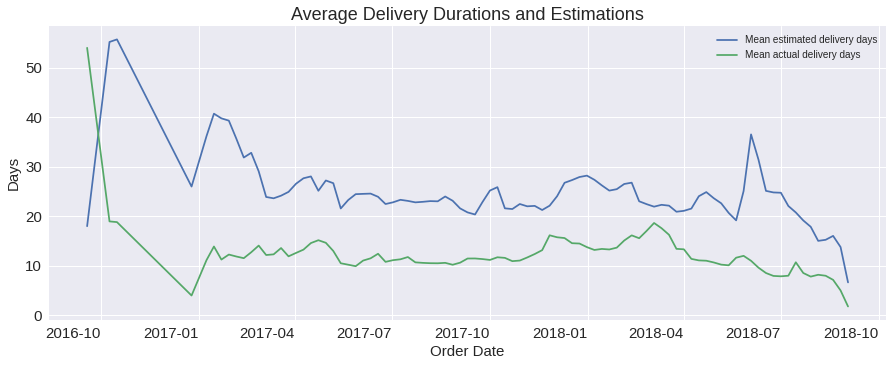

In [29]:
#trend and seasonality
#line graph of total sale volumes by month of time purchase
#tsdf2 <- master_df  %>% filter(product_category_name_english %in% top80sales$product_category_name_english) %>% 
#            group_by(order_purchase_timestamp) %>% 
#                summarise(sales_volume = sum(qty))


plt.figure(figsize=(15,6))
sales_estdelivery.plot(label='Mean estimated delivery days')
sales_delivery.plot(label='Mean actual delivery days')
plt.xlabel('Order Date', fontsize=15)
plt.ylabel('Days', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Average Delivery Durations and Estimations', fontsize=18)
plt.xticks(rotation = 0)
plt.legend(title_fontsize=12,fancybox=True)
plt.show()

#want to plot holidays on here but don't know how

Now we will investigate trend and seasonality of sale volumes by month, weekday, hour


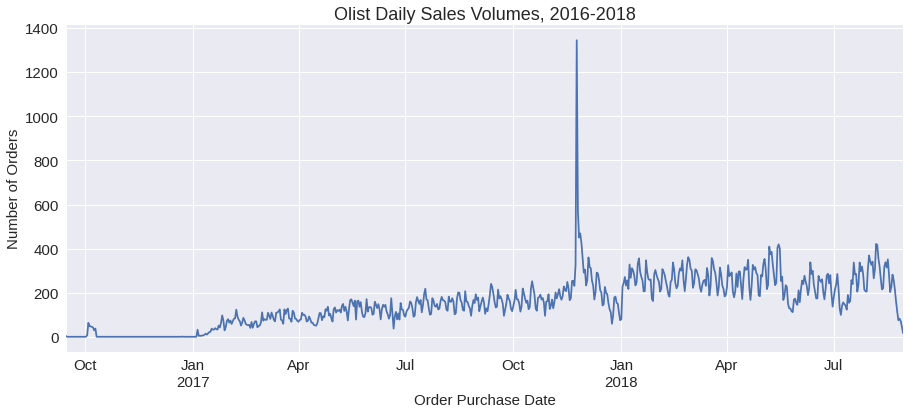

In [30]:
#trend and seasonality
#line graph of total sale volumes by month of time purchase
#tsdf2 <- master_df  %>% filter(product_category_name_english %in% top80sales$product_category_name_english) %>% 
#            group_by(order_purchase_timestamp) %>% 
#                summarise(sales_volume = sum(qty))


plt.figure(figsize=(15,6))
sales.set_index('order_purchase_timestamp').qty.resample('D').sum().plot()
plt.xlabel('Order Purchase Date', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Olist Daily Sales Volumes, 2016-2018', fontsize=18)
plt.show()

#want to plot holidays on here but don't know how

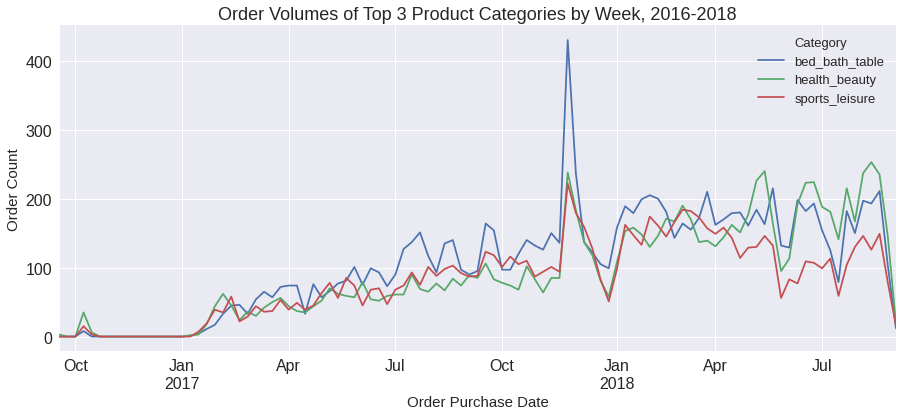

In [32]:
#sales by top 3 best selling categories
import matplotlib.dates as mdates
sales_cat3 = sales[sales['product_category_name_eng'].isin(["bed_bath_table", "health_beauty", "sports_leisure"])]
sales_cat3 = sales_cat3.groupby(['order_purchase_timestamp','product_category_name_eng']).sum()['qty'].unstack()
sales_cat3.resample('W').sum().plot(figsize = (15,6), legend=True)
plt.xlabel('Order Purchase Date', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Order Volumes of Top 3 Product Categories by Week, 2016-2018', fontsize= 18)
plt.legend(title="Category", title_fontsize=13, fontsize=13, fancybox=True)
plt.show()

In [33]:
#Average sales per day of week
sales.head(10)


,order_id,product_id,seller_id,shipping_limit_date,qty,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_eng,product_photos_qty,product_description_length,product_name_length,total_price,est_delivery_days,delivery_days
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,1.0,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,cool_stuff,4.0,598.0,58.0,72.19,15,7
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,1.0,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,pet_shop,2.0,239.0,56.0,259.83,18,16
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,1.0,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,furniture_decor,2.0,695.0,59.0,216.87,21,7
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,1.0,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,perfumery,1.0,480.0,42.0,25.78,11,6
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,1.0,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,garden_tools,1.0,409.0,59.0,218.04,40,25
5,00048cc3ae777c65dbb7d2a0634bc1ea,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,1.0,21.90,12.69,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06,housewares,1.0,558.0,36.0,34.59,21,6
6,00054e8431b9d7675808bcb819fb4a32,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,1.0,19.90,11.85,32e2e6ab09e778d99bf2e0ecd4898718,delivered,2017-12-10 11:53:48,2017-12-10 12:10:31,2017-12-12 01:07:48,2017-12-18 22:03:38,2018-01-04,telephony,1.0,815.0,52.0,31.75,24,8
7,000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,1.0,810.00,70.75,9ed5e522dd9dd85b4af4a077526d8117,delivered,2018-07-04 12:08:27,2018-07-05 16:35:48,2018-07-05 12:15:00,2018-07-09 14:04:07,2018-07-25,garden_tools,3.0,1310.0,39.0,880.75,20,5
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,1.0,145.95,11.65,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29,health_beauty,1.0,493.0,59.0,157.60,9,9
9,0005f50442cb953dcd1d21e1fb923495,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,1.0,53.99,11.40,351d3cb2cee3c7fd0af6616c82df21d3,delivered,2018-07-02 13:59:39,2018-07-02 14:10:56,2018-07-03 14:25:00,2018-07-04 17:28:31,2018-07-23,books_technical,1.0,1192.0,52.0,65.39,20,2


In [34]:
print("Dataset contains orders made from", sales['order_purchase_timestamp'].min().strftime("%d %B, %Y"), "to", sales['order_purchase_timestamp'].max().strftime("%d %B, %Y"))

Dataset contains orders made from 15 September, 2016 to 29 August, 2018


In [35]:
sales['buy_day']=sales['order_purchase_timestamp'].dt.day_name()
sales['buy_month']=sales['order_purchase_timestamp'].dt.month_name()
sales['buy_hour'] = sales['order_purchase_timestamp'].dt.hour # Extracting hour from deadline
sales['buy_year'] = sales['order_purchase_timestamp'].dt.year
sales.buy_year.unique()
sales.groupby('buy_year').size()

buy_year
2016      287
2017    45125
2018    54768
dtype: int64

In [36]:
#sales_time = sales.groupby(['order_purchase_timestamp']).sum()['qty'].reset_index()

sales_time=sales.groupby(['buy_month', 'buy_year']).sum()['qty'].reset_index()

sales_2017=sales_time[sales_time['buy_year']==2017]
sales_2017['buy_month'] = pd.Categorical(sales_2017['buy_month'], ['January','February','March','April','May','June','July','August','September','October','November','December'])
sales_2017=sales_2017.sort_values('buy_month')
#sales_2017

sales_2018=sales_time[sales_time['buy_year']==2018]
sales_2018['buy_month'] = pd.Categorical(sales_2018['buy_month'], ['January','February','March','April','May','June','July','August','September'])
sales_2018=sales_2018.sort_values('buy_month')
#sales_2018

sales_1718=sales[(sales['order_purchase_timestamp'] >= '2017-09-01') &(sales['order_purchase_timestamp'] < '2018-09-01')]
sales_1718=sales_1718.groupby(['buy_month', 'buy_year']).sum()['qty'].reset_index()  

sales_1718['buy_month'] = pd.Categorical(sales_1718['buy_month'], ['January','February','March','April','May','June','July','August','September','October','November','December'])
sales_1718=sales_1718.sort_values('buy_month')
sales_1718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,buy_month,buy_year,qty
4,January,2018,8037.0
3,February,2018,7519.0
7,March,2018,8017.0
0,April,2018,7827.0
8,May,2018,7810.0
6,June,2018,7007.0
5,July,2018,6960.0
1,August,2018,7142.0
11,September,2017,4736.0
10,October,2017,5214.0


In [ ]:
sales_time.head(10)

,buy_month,buy_year,qty
0,April,2017,2569.0
1,April,2018,7827.0
2,August,2017,4797.0
3,August,2018,7142.0
4,December,2016,1.0
5,December,2017,6187.0
6,February,2017,1845.0
7,February,2018,7519.0
8,January,2017,911.0
9,January,2018,8037.0


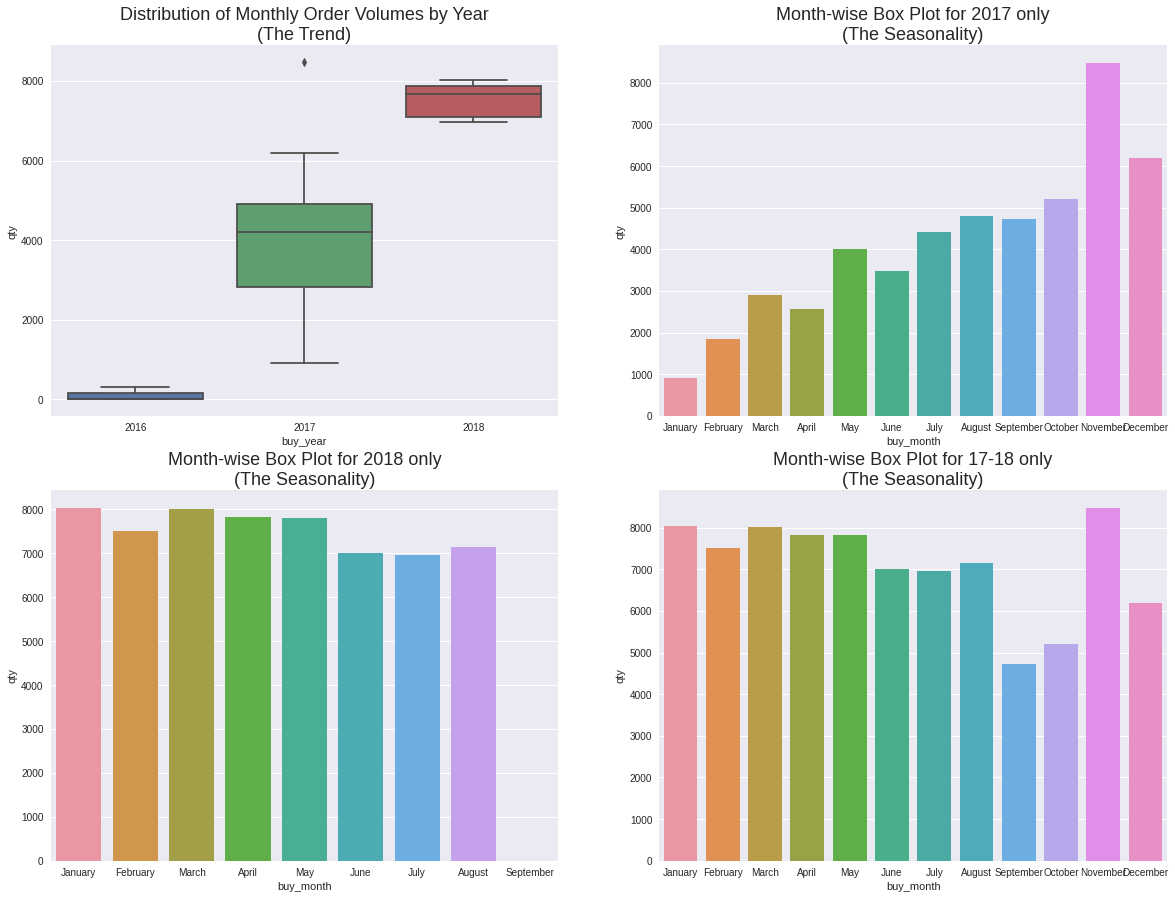

In [37]:

# Draw Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
sns.boxplot(x='buy_year', y='qty', data=sales_time, ax=ax1)
sns.barplot(x='buy_month', y='qty', data=sales_2017, ax=ax2)
sns.barplot(x='buy_month', y='qty', data=sales_2018, ax=ax3)
sns.barplot(x='buy_month', y='qty', data=sales_1718, ax=ax4)

# Set Title
ax1.set_title('Distribution of Monthly Order Volumes by Year\n(The Trend)', fontsize=18); 
ax2.set_title('Month-wise Box Plot for 2017 only\n(The Seasonality)', fontsize=18)
ax3.set_title('Month-wise Box Plot for 2018 only\n(The Seasonality)', fontsize=18)
ax4.set_title('Month-wise Box Plot for 17-18 only\n(The Seasonality)', fontsize=18)
plt.show()




In [38]:
sales_time['buy_month'] = pd.Categorical(sales_time['buy_month'], ['January','February','March','April','May','June','July','August','September','October','November','December'])
sales_time = sales_time.sort_values('buy_month')
sales_time_graph = sales_time[sales_time['qty']!=1]
#sales_time_graph

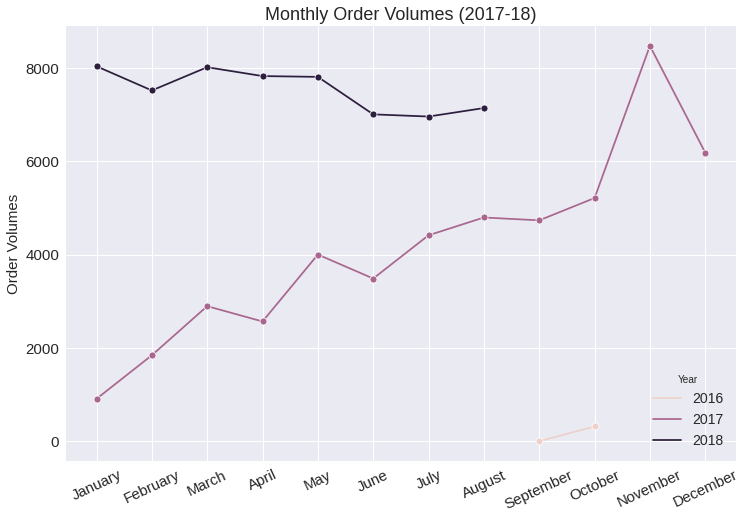

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

#sns.barplot(x='buy_month', y='qty', data=sales_1718)
sns.lineplot(x="buy_month", y="qty", hue="buy_year", data=sales_time_graph, marker="o")
ax.set_title('Monthly Order Volumes (2017-18)', fontsize=18)
ax.set_ylabel('Order Volumes', fontsize=15)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.xticks(rotation = 25)
plt.legend(title="Year", fontsize='14')
plt.show()


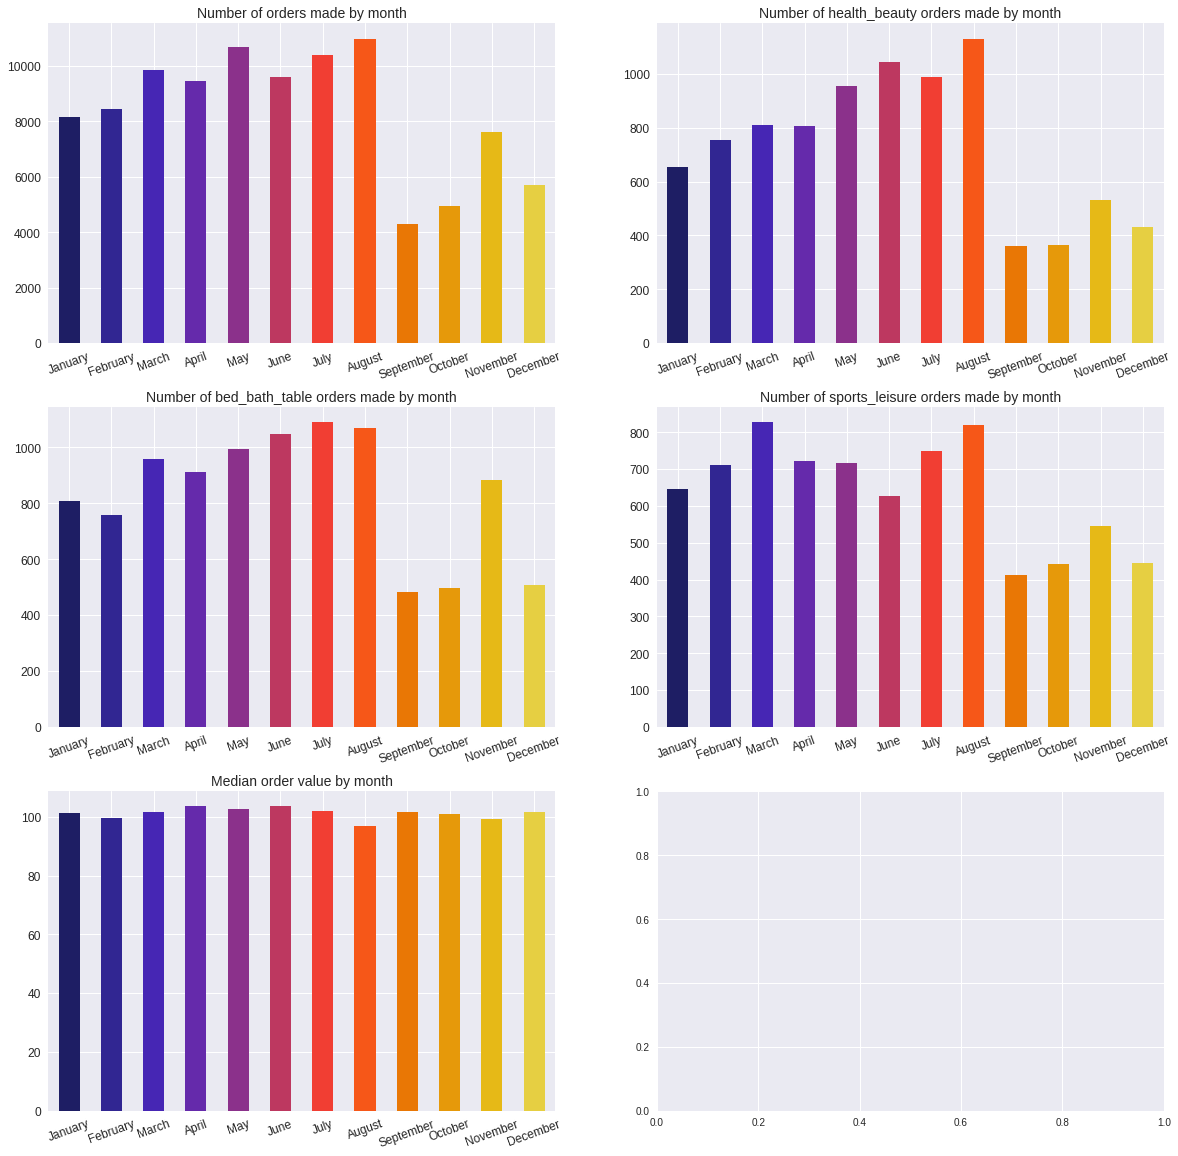

In [40]:
# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))

color1 = cm.CMRmap(np.linspace(0.1,0.8,sales.buy_month.nunique())) # Setting a colormap
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

#data set is from 09/2016 to 09/2018 so average 2 years. For the yearly trend,  we have chosen to analyze only orders made in the last twelve months (Sep2017 to Aug2018) because prior to that sales are too few and volatile.
sales['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax1)
ax1.set_title('Number of orders made by month', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


#average sales value made by month for each category
sales_health = sales[sales['product_category_name_eng']=='health_beauty']
sales_health['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax2)
ax2.set_title('Number of health_beauty orders made by month', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)

sales_bed = sales[sales['product_category_name_eng']=='bed_bath_table']
sales_bed['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax3)
ax3.set_title('Number of bed_bath_table orders made by month', fontsize=14)
ax3.set_ylabel('', fontsize=12)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)

sales_sports = sales[sales['product_category_name_eng']=='sports_leisure']
sales_sports['buy_month'].value_counts().reindex(months).plot(kind='bar',color=color1, rot=20, ax=ax4)
ax4.set_title('Number of sports_leisure orders made by month', fontsize=14)
ax4.set_ylabel('', fontsize=12)
ax4.set_xlabel('')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)

#median amount of total_price each month:
sales.groupby('buy_month').total_price.median().reindex(months).plot(kind='bar', color=color1, rot=20, ax=ax5)
ax5.set_title('Median order value by month', fontsize=14)
ax5.set_ylabel('', fontsize=12)
ax5.set_xlabel('')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=12)


Monthly trend of sale volumes of top 3 categories is pretty similar to the overall trend - higest sales in the summar months, and lowest in the fall/ winter

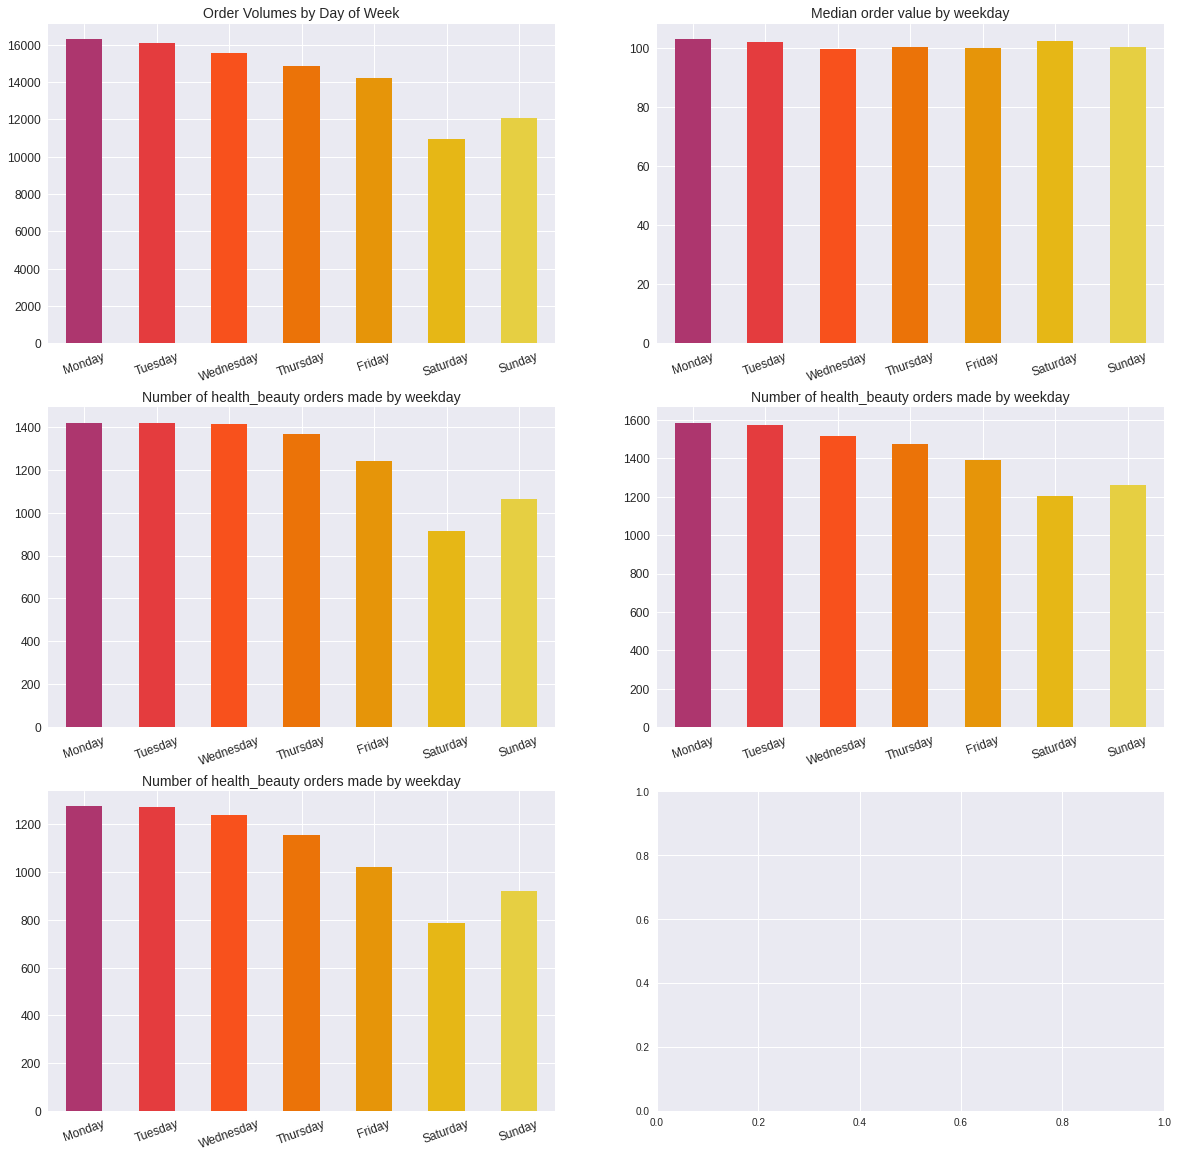

In [41]:
# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,20))

color2 = cm.CMRmap(np.linspace(0.4,0.8,sales.buy_day.nunique())) # Setting a colormap
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#data set is from 09/2016 to 09/2018 so average 2 years 
sales['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax1)
ax1.set_title('Order Volumes by Day of Week', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
#ax1.set_xticklabels(' ',rotation=90)

#median amount of total_price each day of week:
sales.groupby('buy_day').total_price.median().reindex(weekdays).plot(kind='bar', color=color2, rot=20, ax=ax2)
ax2.set_title('Median order value by weekday', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)



#average sales value made by month for each category
sales_health['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax3)
ax3.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax3.set_ylabel('', fontsize=12)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=12)

#average sales value made by month for each category
sales_bed['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax4)
ax4.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax4.set_ylabel('', fontsize=12)
ax4.set_xlabel('')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=12)

#average sales value made by month for each category
sales_sports['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20, ax=ax5)
ax5.set_title('Number of health_beauty orders made by weekday', fontsize=14)
ax5.set_ylabel('', fontsize=12)
ax5.set_xlabel('')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=12)



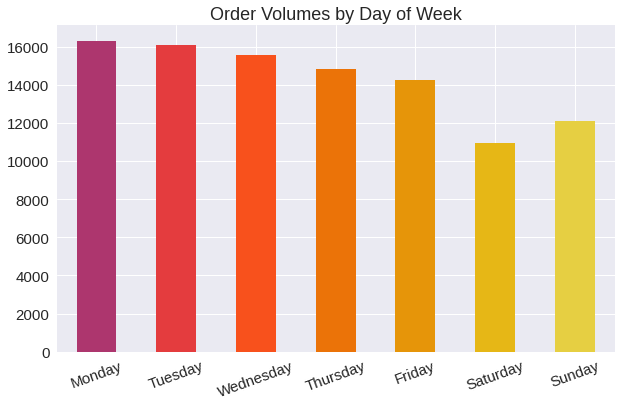

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
sales['buy_day'].value_counts().reindex(weekdays).plot(kind='bar',color=color2, rot=20)
ax.set_title('Order Volumes by Day of Week', fontsize=18)
ax.set_ylabel('')
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

Weekly trend seems to be the same by category as overall. Mondays sell the most while saturdays sell the least.

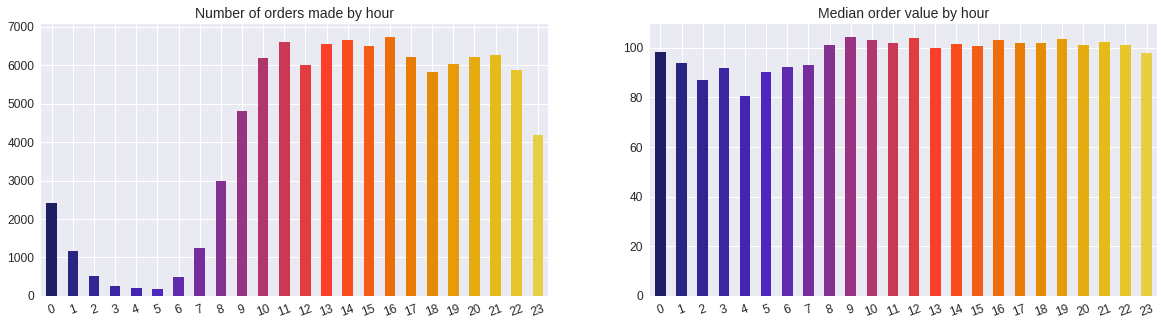

In [43]:

# Plotting
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5))

color3 = cm.CMRmap(np.linspace(0.1,0.8,sales.buy_hour.nunique())) # Setting a colormap
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

#data set is from 09/2016 to 09/2018 so average 2 years 
sales['buy_hour'].value_counts().reindex(hours).plot(kind='bar',color=color3, rot=20, ax=ax1)
ax1.set_title('Number of orders made by hour', fontsize=14)
ax1.set_ylabel('', fontsize=12)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)

#median amount of total_price by hour of the day
sales.groupby('buy_hour').total_price.median().reindex(hours).plot(kind='bar', color=color3, rot=20, ax=ax2)
ax2.set_title('Median order value by hour', fontsize=14)
ax2.set_ylabel('', fontsize=12)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)


In [44]:

sales['Morning'] = sales['buy_hour'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
sales['Afternoon'] = sales['buy_hour'].apply(lambda x: 1 if 12 <= x <= 17 else 0)
sales['Evening'] = sales['buy_hour'].apply(lambda x: 1 if 18 <= x <= 23 else 0)
sales['Overnight'] = sales['buy_hour'].apply(lambda x: 1 if 0 <= x <= 5 else 0)

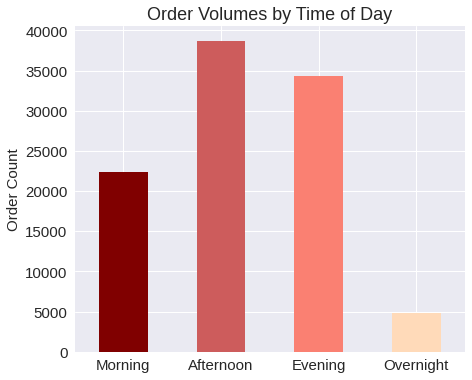

In [45]:
# THIS GRAPH IS FOR QUESTION 2, WILL MOVE LATER

#color_buy = ['darkcyan','lightseagreen','mediumturquoise','skyblue']
color_buy = ['maroon','indianred','salmon','peachpuff']
sales[['Morning','Afternoon','Evening','Overnight']].sum().plot(kind='bar',color=color_buy,figsize=(7,6))
plt.xticks(rotation = 0)
plt.title('Order Volumes by Time of Day', fontsize=18)
plt.xlabel('')
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [46]:
#left join sales (all order details) with reviews
orders_reviews = pd.merge(sales, reviews, on='order_id',how='left')
orders_reviews = orders_reviews[~orders_reviews['title'].isnull()]
orders_reviews.info()
#null_reviews = orders_reviews[orders_reviews.isnull().any(axis=1)]
#null_reviews.sort

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100068 entries, 0 to 100760
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100068 non-null  object        
 1   product_id                     100068 non-null  object        
 2   seller_id                      100068 non-null  object        
 3   shipping_limit_date            100068 non-null  datetime64[ns]
 4   qty                            100068 non-null  float64       
 5   price                          100068 non-null  float64       
 6   freight_value                  100068 non-null  float64       
 7   customer_id                    100068 non-null  object        
 8   order_status                   100068 non-null  object        
 9   order_purchase_timestamp       100068 non-null  datetime64[ns]
 10  order_approved_at              100068 non-null  datetime64[ns]
 11  

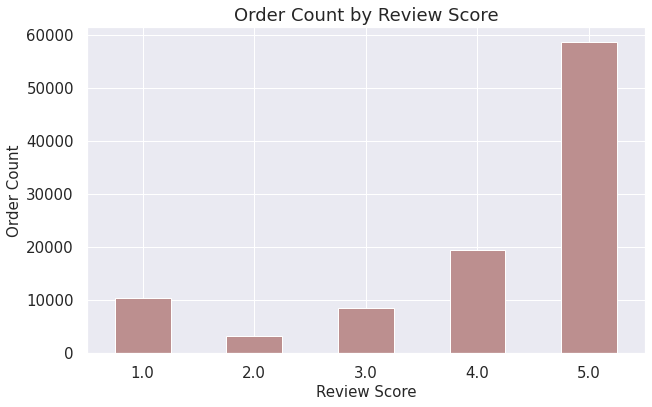

In [47]:

sns.set(rc={'figure.figsize':(10,6)})
orders_reviews.groupby('score').size().plot.bar(color = 'rosybrown')
plt.title('Order Count by Review Score', fontsize=18)
plt.xlabel('Review Score', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(rotation = 0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
plt.show()


In [48]:
orders_reviews.head(5)
cat_score = orders_reviews.groupby(['product_category_name_eng'])['score'].mean().reset_index()
cat_score = cat_score.sort_values(by='score', ascending=False)
cat_score_top10 = cat_score.head(10)
cat_score_bot10 = cat_score.tail(10)
#plot.bar(figsize=(12,6))
#orders_reviews.groupby(['product_category_name_eng']).size()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '10 Categories with Highest Average Review Score')

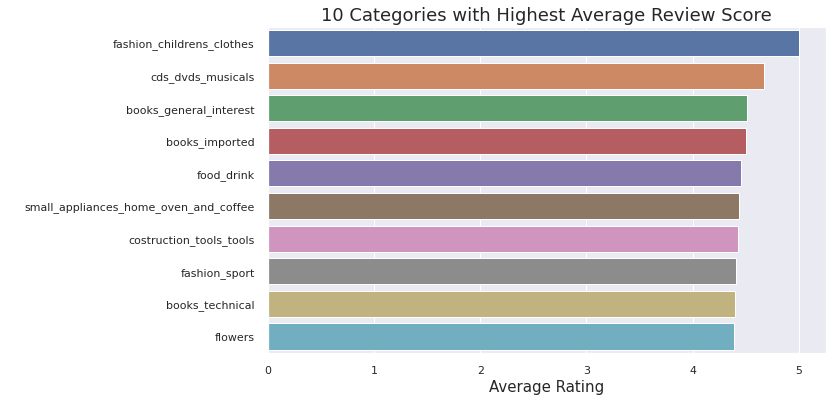

In [49]:
plt.figure(figsize=(10,6))
# bar plot with matplotlib
sns.barplot('score','product_category_name_eng', data=cat_score_top10, orient = 'h')
plt.xlabel("Average Rating", size=15)
plt.ylabel(" ")
plt.title("10 Categories with Highest Average Review Score", size=18)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '10 Categories with Lowest Average Review Score')

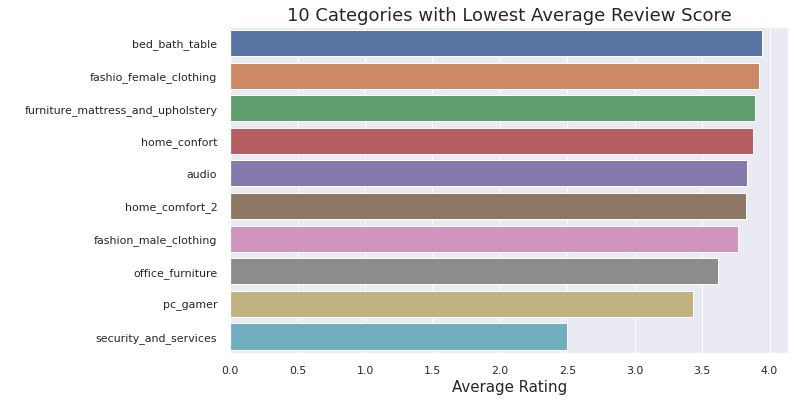

In [50]:
plt.figure(figsize=(10,6))
# bar plot with matplotlib
#plt.bar('product_category_name_eng', 'score',data=cat_score_bot10)
sns.barplot('score','product_category_name_eng', data=cat_score_bot10, orient='h')
plt.xlabel("Average Rating", size=15)
plt.ylabel(" ")
plt.title("10 Categories with Lowest Average Review Score", size=18)

In [51]:
cat_score2 = orders_reviews.groupby(['product_category_name_eng']).agg({'score': 'mean', 'total_price': 'sum', 'order_id': 'count'}).reset_index()
cat_score2 = cat_score2.sort_values(by='score', ascending=False)
cat_score2_500 =  cat_score2[cat_score2['order_id']>500]
cat_score2.order_id.describe()
cat_score2.score.describe()


count    72.000000
mean      4.137266
std       0.297079
min       2.500000
25%       4.052029
50%       4.158501
75%       4.242399
max       5.000000
Name: score, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Review Scores of High Sales Categories')

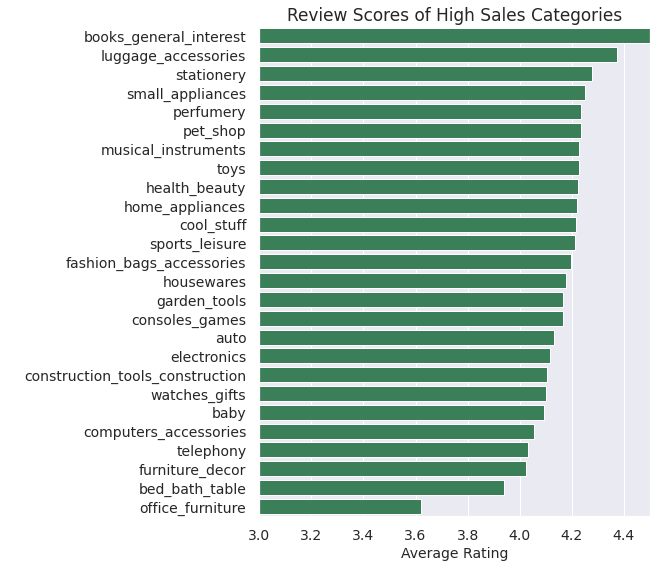

In [52]:

plt.figure(figsize=(7,9))
# bar plot with matplotlib
s = sns.barplot('score','product_category_name_eng', data=cat_score2_500, orient = 'h', color="seagreen")
plt.xlim(3,4.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Average Rating", size=14)
plt.ylabel(" ")
plt.title("Review Scores of High Sales Categories", size=17)


In [ ]:
cat_score2.order_id.mean()

1370.4166666666667